In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import gzip
import json
import sys
import re

%matplotlib inline

### Parser sobre o arquivo de entrada ``amazon-meta.txt.gz`` para gerar um JSON com a estrutura do arquivo

In [2]:
def get_line_number(file_path):
    sys.stderr.write("Counting line number of {}".format(file_path))
    
    with gzip.open(file_path, 'rb') as file:
        for lines, l in enumerate(file):
            pass
        
    return lines

In [3]:
def parser(filename, total):
    IGNORE_FIELDS = ['Total items', 'reviews']
    f = gzip.open(filename, 'r')
    entry = {}
    categories = []
    reviews = []
    similar_items = []
    
    for line in tqdm(f, total=total):
        line = line.decode("utf-8").strip()
        colonPos = line.find(':')
        
        if line.startswith("Id"):
            if reviews:
                entry["reviews"] = reviews
            if categories:
                entry["categories"] = categories
            
            yield entry
            entry = {}
            categories = []
            reviews = []
            rest = line[colonPos+2:]
            entry["id"] = rest.strip()
        
        elif line.startswith("similar"):
            similar_items = line.split()[2:]
            entry['similar_items'] = similar_items
            
        elif line.find("cutomer:") != -1:
            review_info = line.split()
            reviews.append({'data': review_info[0],'customer_id': review_info[2],'rating': int(review_info[4]),'votes': int(review_info[6]),'helpful': int(review_info[8])})
            
        elif line.startswith("|"):
            categories.append(line)
            
        elif colonPos != -1:
            eName = line[:colonPos]
            rest = line[colonPos+2:]
            
            if not eName in IGNORE_FIELDS:
                entry[eName] = rest.strip()
                
    if reviews:
        entry["reviews"] = reviews
        
    if categories:
        entry["categories"] = categories
        
    yield entry

Definição do arquivo de entrada:

In [4]:
path_file = 'data/amazon-meta.txt.gz'

In [5]:
line_num = get_line_number(path_file)

Counting line number of data/amazon-meta.txt.gz

In [6]:
with open('data/amazon-meta.json', 'w') as f:
    for e in parser(path_file, total=line_num):
        if e:
            json.dump(e, f)
            f.write('\n')

15010574it [01:56, 128421.27it/s]                              


### Usando SparkSQL propriamente dito

In [3]:
spark = SparkSession.builder.appName('Parte C - Trabalho II').config('spark.some.config.option','some-value').getOrCreate()

In [4]:
# Spark context
sc = spark.sparkContext

In [5]:
path_file = 'data/amazon-meta.json'

In [6]:
amazon_df = spark.read.json(path_file)

#### Esquema do Amazon-meta gerado pelo próprio SparkSQL

In [7]:
amazon_df.printSchema()

root
 |-- ASIN: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- group: string (nullable = true)
 |-- id: string (nullable = true)
 |-- reviews: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- customer_id: string (nullable = true)
 |    |    |-- data: string (nullable = true)
 |    |    |-- helpful: long (nullable = true)
 |    |    |-- rating: long (nullable = true)
 |    |    |-- votes: long (nullable = true)
 |-- salesrank: string (nullable = true)
 |-- similar_items: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)



### Consultas usando DataFrames

(a) Dado produto, listar os 5 comentários mais úteis e com maior avaliação e os 5 comentários mais úteis e com menor avaliação

In [38]:
# id do produto
id = 8

In [81]:
df_tmp_1 = amazon_df.where('id=' + str(id)).select(f.explode_outer(f.col('reviews')).alias('reviews'))

In [86]:
df_tmp_1.select('reviews.*').sort('helpful','rating',ascending=False).show(5)

+--------------+----------+-------+------+-----+
|   customer_id|      data|helpful|rating|votes|
+--------------+----------+-------+------+-----+
| AL5D52NA8F67F|2000-11-19|     13|     5|   16|
|A1OZQCZAK21S6M| 2000-11-1|     12|     5|   13|
| AL5OEDM8TPTKV|2001-10-25|     10|     5|   10|
|A2F1X6YFCJZ1FH|2000-10-31|      9|     5|   10|
|A2WKESDGF2YC8S|2001-12-24|      8|     5|    8|
+--------------+----------+-------+------+-----+
only showing top 5 rows



(b) Dado um produto, listar os produtos similares com maiores vendas do que ele

In [56]:
# id do produto
id = 8

In [57]:
#similar = amazon_df.where('id=' + str(id)).select('similar_items').rdd.flatMap(lambda x: x).collect()[0]

In [58]:
df_tmp = amazon_df.where('id=' + str(id)). \
select(amazon_df.salesrank.alias('salesrank_to_cmp'),f.explode(f.col('similar_items')).alias('ASIN'))

In [70]:
df_tmp.join(amazon_df, df_tmp.ASIN == amazon_df.ASIN).where(df_tmp.salesrank_to_cmp > amazon_df.salesrank). \
select(['id']).show()

+------+
|    id|
+------+
|453513|
| 55461|
|242156|
+------+



In [ ]:
amazon_df.where('id=8')

(c) Dado um produto, mostrar a evolução diária das médias de avaliação ao longo do intervalo de tempo coberto no arquivo de entrada

In [87]:
# id do produto
id = 8

In [88]:
df_tmp_1 = amazon_df.where('id=' + str(id)).select(f.explode(f.col('reviews.data')).alias('reviews.data'))
df_tmp_2 = amazon_df.where('id=' + str(id)).select(f.explode(f.col('reviews.rating')).alias('reviews.rating'))

In [89]:
x = df_tmp_1.rdd.flatMap(lambda x: x).collect()
y = df_tmp_2.rdd.flatMap(lambda x: x).collect()
list_data_rating = [[pair[0], pair[1]] for pair in zip(x,y)]

In [90]:
date_time_transf = [(list_data_rating[i][0].split('-')[0],list_data_rating[i][0].split('-')[1],list_data_rating[i][0].split('-')[2]) for i in range(len(list_data_rating))]
date_time = sorted([datetime.datetime(int(i[0]),int(i[1]),int(i[2])) for i in date_time_transf])

for i in range(len(list_data_rating)):
    list_data_rating[i][0] = date_time[i]
    
x = [date_time[0] for date_time in list_data_rating]
y = [date_time[1] for date_time in list_data_rating]

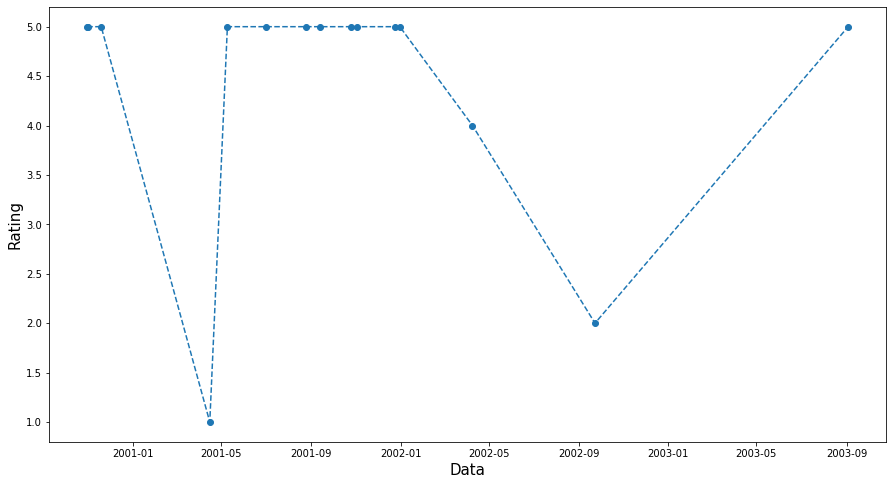

In [91]:
plt.figure(figsize=(15,8))
plt.plot(x,y,'o--')
plt.xlabel('Data',fontsize=15)
plt.ylabel('Rating',fontsize=15)
plt.show()

#caso não tenha plotado nenhum ponto é porque o produto não tem review

(d) Listar os 10 produtos lideres de venda em cada grupo de produtos

In [75]:
df_tmp_1 = amazon_df.filter('salesrank >= 0').withColumn('id_salesrank', f.struct(f.col('id'),f.col('salesrank'))). \
groupBy(amazon_df.group).agg(f.collect_list('id_salesrank').alias('id_salesrank'))

In [76]:
df_tmp_2 = df_tmp_1.select(df_tmp_1.group,f.explode_outer(f.col('id_salesrank')).alias('id_salesrank')). \
select('group','id_salesrank.*').sort('salesrank')

In [77]:
#df_tmp_2.filter(~f.isnull('group')).sort('salesrank').filter('salesrank >= 0').show()
df_tmp_2.groupBy('group').agg(f.collect_list('id')).show()

+------------+--------------------+
|       group|    collect_list(id)|
+------------+--------------------+
|       Video|[548526, 297444, ...|
|         Toy|[272037, 465900, ...|
|         DVD|[548547, 548548, ...|
|      Sports|            [310467]|
|Baby Product|            [197564]|
| Video Games|             [51902]|
|        Book|[548511, 548512, ...|
|       Music|[548536, 548544, ...|
|    Software|[456958, 527037, ...|
|          CE|[224434, 253628, ...|
+------------+--------------------+



(e) Listar os 10 produtos com a maior média de avaliações úteis positivas por produto

In [75]:
df_tmp_1 = amazon_df.select(amazon_df.id,f.explode_outer(f.col('reviews.helpful')).alias('reviews_helpful'))

In [81]:
df_tmp_2 = df_tmp_1.withColumn('reviews_helpful', f.when(df_tmp_1.reviews_helpful.isNull(), 0). \
                               otherwise(df_tmp_1.reviews_helpful))

In [94]:
df_tmp_2.groupBy('id').mean().orderBy('avg(reviews_helpful)',ascending=False).show(10)

+------+--------------------+
|    id|avg(reviews_helpful)|
+------+--------------------+
|380551|               243.0|
|110544|               233.0|
|523037|               203.0|
|178270|               197.0|
|250701|               196.0|
|312621|  186.46511627906978|
|411581|  186.34883720930233|
|403662|  186.32558139534885|
|357193|  186.30232558139534|
| 69111|               183.0|
+------+--------------------+
only showing top 10 rows



(f) Listar a 5 categorias de produto com a maior média de avaliações úteis positivas por produto

In [69]:
df_tmp_1 = amazon_df.filter('reviews IS NOT NULL').select('group','reviews.helpful'). \
select('group', f.explode_outer('helpful').alias('helpful'))

In [74]:
df_tmp_1.groupBy('group').mean().orderBy('avg(helpful)',ascending=False).show(5)

+------------+------------------+
|       group|      avg(helpful)|
+------------+------------------+
|Baby Product|29.333333333333332|
|      Sports|              27.2|
|         Toy|21.972972972972972|
|    Software| 17.46153846153846|
| Video Games|15.333333333333334|
+------------+------------------+
only showing top 5 rows



(g) Listar os 10 clientes que mais fizeram comentários por grupo de produto

In [12]:
df_tmp_1 = amazon_df.filter('group IS NOT NULL'). \
select(amazon_df.group,f.explode_outer(f.col('reviews.customer_id')).alias('customer_id'))

In [23]:
df_tmp_2 = df_tmp_1.groupBy('group','customer_id').agg(f.count('customer_id')). \
sort('count(customer_id)',ascending=False).filter('customer_id IS NOT NULL')

In [25]:
df_tmp_2.groupBy('group').agg(f.collect_list('customer_id')).show()

+------------+-------------------------+
|       group|collect_list(customer_id)|
+------------+-------------------------+
|       Video|     [ATVPDKIKX0DER, A...|
|         Toy|     [AH4M07U4YC695, A...|
|         DVD|     [ATVPDKIKX0DER, A...|
|      Sports|     [A2RHSQZ7MAKKCO, ...|
|Baby Product|     [A37TFIP0OMKGMW, ...|
| Video Games|     [A3C811U31YG6FS, ...|
|        Book|     [ATVPDKIKX0DER, A...|
|       Music|     [ATVPDKIKX0DER, A...|
|    Software|     [AK9MWTH6LJF64, A...|
|          CE|     [A1SFX3CR838F36, ...|
+------------+-------------------------+



### Consultas sobre view temporária

In [161]:
amazon_df.createOrReplaceTempView('amazon')

(a) Dado produto, listar os 5 comentários mais úteis e com maior avaliação e os 5 comentários mais úteis e com menor avaliação

In [112]:
# id do produto
id = 8

In [117]:
df_temp_1 = amazon_df.filter('id = ' + str(id)).select('id',f.explode(amazon_df.reviews).alias('reviews')).select('reviews.*',"id")

In [118]:
df_temp_1.createOrReplaceTempView('amazon_a')

In [121]:
sql = '(SELECT * FROM amazon_a WHERE id=' + str(id) + ' ORDER BY helpful DESC, rating DESC LIMIT 5) UNION ALL (SELECT * FROM amazon_a WHERE id=' + str(2) + ' ORDER BY helpful DESC, rating ASC LIMIT 5)'

In [122]:
spark.sql(sql).show()

+--------------+----------+-------+------+-----+---+
|   customer_id|      data|helpful|rating|votes| id|
+--------------+----------+-------+------+-----+---+
| AL5D52NA8F67F|2000-11-19|     13|     5|   16|  8|
|A1OZQCZAK21S6M| 2000-11-1|     12|     5|   13|  8|
| AL5OEDM8TPTKV|2001-10-25|     10|     5|   10|  8|
|A2F1X6YFCJZ1FH|2000-10-31|      9|     5|   10|  8|
|A2WKESDGF2YC8S|2001-12-24|      8|     5|    8|  8|
+--------------+----------+-------+------+-----+---+



(b) Dado um produto, listar os produtos similares com maiores vendas do que ele

In [100]:
# id do produto
id = 8

In [124]:
#sql = ''

In [125]:
#spark.sql(sql).show()

(c) Dado um produto, mostrar a evolução diária das médias de avaliação ao longo do intervalo de tempo coberto no arquivo de entrada

In [103]:
# id do produto
id = 8

In [159]:
sql = '(SELECT EXPLODE(reviews.data) FROM amazon WHERE id=' + str(id) + ') UNION (SELECT EXPLODE(reviews.rating) FROM amazon WHERE id=' + str(id) + ')'

In [160]:
spark.sql(sql).show()

+----------+
|       col|
+----------+
|2000-10-31|
|  2003-9-3|
| 2001-11-3|
|2001-10-25|
|  2001-7-1|
|2000-11-19|
|         5|
| 2000-11-1|
|2001-12-31|
|2001-12-24|
| 2001-8-25|
|         1|
| 2002-9-23|
| 2001-5-10|
| 2001-9-13|
|         4|
|  2002-4-9|
| 2001-4-16|
|         2|
+----------+



(d) Listar os 10 produtos lideres de venda em cada grupo de produtos

In [130]:
#sql = ''

In [132]:
#spark.sql(sql).show()

(e) Listar os 10 produtos com a maior média de avaliações úteis positivas por produto

In [93]:
df_temp_1 = amazon_df.select('id',f.explode('reviews.helpful').alias('helpful'))

In [94]:
df_temp_1.createOrReplaceTempView('amazon_e')

In [99]:
sql = 'SELECT id, avg(helpful) FROM amazon_e GROUP BY id ORDER BY avg(helpful) DESC LIMIT 10'

In [100]:
spark.sql(sql).show()

+------+------------------+
|    id|      avg(helpful)|
+------+------------------+
|380551|             243.0|
|110544|             233.0|
|523037|             203.0|
|178270|             197.0|
|250701|             196.0|
|312621|186.46511627906978|
|411581|186.34883720930233|
|403662|186.32558139534885|
|357193|186.30232558139534|
| 69111|             183.0|
+------+------------------+



(f) Listar a 5 categorias de produto com a maior média de avaliações úteis positivas por produto

In [108]:
df_temp_1 = amazon_df.select('group',f.explode('reviews.helpful').alias('helpful'))

In [109]:
df_temp_1.createOrReplaceTempView('amazon_f')

In [110]:
sql = 'SELECT group, avg(helpful) FROM amazon_f GROUP BY group ORDER BY avg(helpful) DESC LIMIT 5'

In [111]:
spark.sql(sql).show()

+------------+------------------+
|       group|      avg(helpful)|
+------------+------------------+
|Baby Product|29.333333333333332|
|      Sports|              27.2|
|         Toy|21.972972972972972|
|    Software| 17.46153846153846|
| Video Games|15.333333333333334|
+------------+------------------+



(g) Listar os 10 clientes que mais fizeram comentários por grupo de produto

In [133]:
sql = 'SELECT group, count(*) as count FROM amazon WHERE group IS NOT NULL GROUP BY group ORDER BY count(*) DESC'

In [134]:
spark.sql(sql).show()

+------------+------+
|       group| count|
+------------+------+
|        Book|393561|
|       Music|103144|
|       Video| 26131|
|         DVD| 19828|
|         Toy|     8|
|    Software|     5|
|          CE|     4|
|Baby Product|     1|
|      Sports|     1|
| Video Games|     1|
+------------+------+

